과제 내용 : 기계 독해 (LSTM 기반 영영화 긍/부정 결과 데이터셋 결과 기반 예측.)


#Mission! : 

vocab tockenizer, batch 크기 등과 

LSTM 모델의 하이퍼파라미터를 튜닝해서 최대한 

Accuracy를 올려보세요!

In [1]:
pip install torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.


In [2]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import urllib.request
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cpu


데이터 깃헙에서 받아주겠습니다. 대표적인 영어데이터인 IMDB 리뷰데이터입니다.

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7feeb14a17f0>)

In [5]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='utf-8')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


첫 열은 영화 리뷰로, 둘째 열은 긍정/부정을 나타내는 열입니다. (긍정 1 부정 0)

In [6]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


샘플 개수 50000개, 3.5 0.5 1로 나눠주겠습니다.

In [7]:
train_df = df[:35000]
val_df = df[35000:40000]
test_df = df[40000:]
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

In [8]:
from torchtext.legacy import data # torchtext.data 임포트

# 필드 정의
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

In [9]:
from torchtext.legacy.data import TabularDataset

train_data, val_data, test_data = TabularDataset.splits(
        path='.', train='train_data.csv', validation='val_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

In [10]:
# csv로 저장했던 훈련 데이터와 테스트 데이터의 크기 확인
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('검증 샘플의 개수 : {}'.format(len(val_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))

훈련 샘플의 개수 : 35000
검증 샘플의 개수 : 5000
테스트 샘플의 개수 : 10000


In [11]:
print(vars(train_data[0]))

{'text': ['my', 'family', 'and', 'i', 'normally', 'do', 'not', 'watch', 'local', 'movies', 'for', 'the', 'simple', 'reason', 'that', 'they', 'are', 'poorly', 'made,', 'they', 'lack', 'the', 'depth,', 'and', 'just', 'not', 'worth', 'our', 'time.<br', '/><br', '/>the', 'trailer', 'of', '"nasaan', 'ka', 'man"', 'caught', 'my', 'attention,', 'my', 'daughter', 'in', "law's", 'and', "daughter's", 'so', 'we', 'took', 'time', 'out', 'to', 'watch', 'it', 'this', 'afternoon.', 'the', 'movie', 'exceeded', 'our', 'expectations.', 'the', 'cinematography', 'was', 'very', 'good,', 'the', 'story', 'beautiful', 'and', 'the', 'acting', 'awesome.', 'jericho', 'rosales', 'was', 'really', 'very', 'good,', "so's", 'claudine', 'barretto.', 'the', 'fact', 'that', 'i', 'despised', 'diether', 'ocampo', 'proves', 'he', 'was', 'effective', 'at', 'his', 'role.', 'i', 'have', 'never', 'been', 'this', 'touched,', 'moved', 'and', 'affected', 'by', 'a', 'local', 'movie', 'before.', 'imagine', 'a', 'cynic', 'like', 'me

In [13]:
# 정의한 필드에 .build_vocab()도구를 사용해 단어 집합 생성
TEXT.build_vocab(train_data, min_freq=5, max_size=10000) # min_freq: 단어 집합에 추가시 단어의 최소 등장 빈도 조건을 추가, max_size: 단어 집합의 최대 크기 지정

# 생성된 단어 집합의 크기 확인
print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))

단어 집합의 크기 : 10002


In [14]:
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7feeb1504f40>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'this': 10, 'it': 11, 'that': 12, '/><br': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'but': 18, 'on': 19, 'movie': 20, 'his': 21, 'are': 22, 'not': 23, 'you': 24, 'film': 25, 'have': 26, 'he': 27, 'be': 28, 'at': 29, 'one': 30, 'by': 31, 'an': 32, 'they': 33, 'from': 34, 'all': 35, 'who': 36, 'like': 37, 'so': 38, 'just': 39, 'or': 40, 'has': 41, 'about': 42, "it's": 43, 'if': 44, 'her': 45, 'some': 46, 'out': 47, 'what': 48, 'very': 49, 'when': 50, 'more': 51, 'there': 52, 'would': 53, 'even': 54, 'my': 55, 'good': 56, 'she': 57, 'their': 58, 'only': 59, 'no': 60, 'really': 61, 'had': 62, 'up': 63, 'can': 64, 'which': 65, 'see': 66, 'were': 67, 'than': 68, '-': 69, 'we': 70, 'been': 71, 'get': 72, 'into': 73, 'will': 74, 'much': 75, 'because': 76, 'most': 77, 'story': 78, 'how': 7

In [15]:
# Iterator 임포트
from torchtext.legacy.data import Iterator

# 배치 크기 20 지정
batch_size = 20

train_loader = Iterator(dataset=train_data, batch_size = batch_size)
val_loader = Iterator(dataset=val_data, batch_size = batch_size)
test_loader = Iterator(dataset=test_data, batch_size = batch_size)

print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('검증 데이터의 미니 배치 수 : {}'.format(len(val_loader)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_loader)))

훈련 데이터의 미니 배치 수 : 1750
검증 데이터의 미니 배치 수 : 250
테스트 데이터의 미니 배치 수 : 500


In [16]:
# 첫번째 미니 배치를 batch 변수에 저장
batch = next(iter(train_loader)) # 첫번째 미니배치

# 첫번째 미니 배치의 자료형 확인
print(type(batch))

# 실제 데이터 센서에 접근하기 위해 정의한 필드명(text)을 사용해야함
print(batch.text)

<class 'torchtext.legacy.data.batch.Batch'>
tensor([[ 497,    0, 5095,    4, 5106,   10,    0,   78,  418,   19,    2, 7116,
            5, 2513,    0,    8,    0,    0,    0,   14],
        [ 380,    7,   30,    5,    2,  119,    4,    2,  322,  195,   12,   62,
         5859,    8,   55,  511,    9, 3709,    4,  217],
        [1056, 1769,    0,   27,   14,   86,    8,    0,    0,    4,   62,    3,
           56,    0,    8,    0,   18,  209,    8,    0],
        [   8,  791,    5,   97,  908,   69,   40,  580, 6837,   69,    9,  224,
         4434,    6,   72,    8,    0,    4,   90,    3],
        [ 532, 8784,   41, 9124,    2,  469,    5,  654,  270, 1312,   27,   41,
         2211,   12,   24,   81,   23,  309, 4015,  904],
        [ 148, 2963,   79,   99,  877,   19,   10,  130,   22,   42,   79, 7615,
           11,  668,  286,  148,   23,  184,    5,    2],
        [1055,    6,    2,    0, 1851,    0,  565,    7,    3,  836, 2818,    0,
            3,  307,  405,    5, 3586,  2

# LSTM 모델 구성

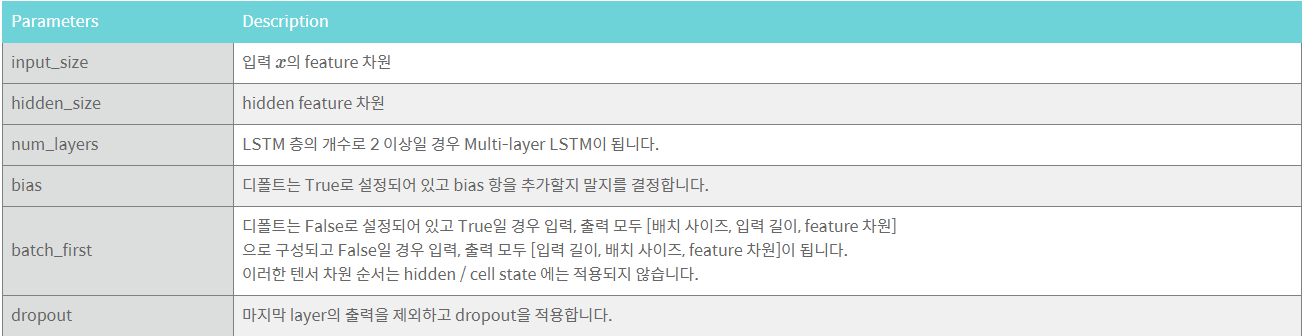

In [17]:
class BasicLSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):
        super(BasicLSTM, self).__init__()
        print("Building Basic LSTM model...")

        
        self.n_layers = n_layers 
        #n_vocab : Vocab 안에 있는 단어의 개수, embed_dim : 임베딩 된 단어 텐서가 갖는 차원 값(dimension)
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
#---------------------------------------------- 여기 밑부터 작성해주세요~-------------------------------------------------
        #앞에서 정의한 하이퍼 파라미터를 넣어 LSTM 정의
        self.lstm = nn.LSTM(input_size=embed_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.n_layers,
                            batch_first=True)
        
        #Input: LSTM의 hidden state vector(context), Output : Class probability vector
        self.out = nn.Linear(self.hidden_dim, n_classes)
#----------------------------------------------여기까지-------------------------------------------------

    def forward(self, x):
        # Input data: 한 batch 내 모든 영화 평가 데이터
        
        x = self.embed(x)# 영화 평 임베딩

        # 초기 hidden, cell state vector를 zero vector로 생성
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
#------------------------------------------------여기 밑부터 작성해주세요-------------------------------------------------------------
        output, (h_t, c_t) = self.lstm(x, (h_0, c_0)) 
        #print(h_t.shape)
        #(1,64,h) ==> 64 batch-size,  h hidden_dimmension

        # 영화 리뷰 배열들을 압축한 hidden state vector
        # (batch_size, hidden_dim)형태의 텐서 추출
        h_t = h_t.view(-1, self.hidden_dim)

#-------------------------------------------------여기까지---------------------------------------------------------
        # linear layer의 입력으로 주고, 각 클래스 별 결과 logit을 생성.
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit

In [18]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad()# 매번 기울기를 새로 계산하기 위해서 zero 로 초기화
        logit = model(x)#모델의 예측값 logit 계산
        #print(y)
        loss = F.cross_entropy(logit, y)# logit과 실제 label간의 오차를 구하고 기울기 계산
        loss.backward()
        optimizer.step()

In [19]:
def evaluate(model, val_iter):
    """evaluate model"""                   
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:# Validation 데이터셋에 대하여 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    #전체 validation 셋에 대한 평균 loss와 accuracy를 구하는 과정
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [20]:
n_layers = 1
hidden_dim = 32 
n_vocab = len(TEXT.vocab)
embed_dim = 128
n_classes = 2
lr = 0.001
batch_size = 20

In [21]:
model = BasicLSTM(n_layers, hidden_dim, n_vocab, embed_dim, n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic LSTM model...


In [22]:
model

BasicLSTM(
  (embed): Embedding(10002, 128)
  (lstm): LSTM(128, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
EPOCHS = 10
train_iter = train_loader
val_iter = val_loader
test_iter = test_loader

best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[EPOCH: %d] val_loss:%5.2f | val_acc:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[EPOCH: 1] val_loss: 0.62 | val_acc:65.60
[EPOCH: 2] val_loss: 0.58 | val_acc:68.30
[EPOCH: 3] val_loss: 0.61 | val_acc:68.36
[EPOCH: 4] val_loss: 0.63 | val_acc:68.98
[EPOCH: 5] val_loss: 0.73 | val_acc:69.30
[EPOCH: 6] val_loss: 0.85 | val_acc:69.28
[EPOCH: 7] val_loss: 1.00 | val_acc:68.42
[EPOCH: 8] val_loss: 1.15 | val_acc:68.74
[EPOCH: 9] val_loss: 1.26 | val_acc:68.56
[EPOCH: 10] val_loss: 1.50 | val_acc:68.24


In [24]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.58 | 테스트 정확도: 69.25
